# Detecting Changeover with Machine Learning using NC Data and external Sensors

## 6-Phases
This notebook contains all the preliminary models used in the OBerA project.
It belongs to the article "Detecting Changeover with Machine Learning using NC Data and external Sensors" which can be found in Open Access by the following link: <https://www.mdpi.com/1424-8220/21/17/5896/htm>


## Packages used

Except for imblearn other packages used here are rather common for Anaconda distribution. Most of them are of the newest (or rather new) versions as of August 2021. You shall be able replicate the same results with the newest versions of these packages. However, below the version list of the packages used in the imports will be presented.

*For those interested, a 'requirements.txt' (generated by conda) file with all the packages used within the environment was also added to the project*


conda version : 4.10.3

python version : 3.9.6


pandas==1.4.1

numpy==1.22.2

matplotlib==3.5.1

seaborn==0.11.2

tensorflow==2.8.0

scikit-learn==0.23.2

imbalanced-learn==0.7.0

lightgbm==3.3.2

xgboost==1.5.2

catboost==1.0.4

# Imports


In [1]:
# Importing libraries
import pandas as pd #for working with dataframes
import numpy as np #for numerical and vector operations
import matplotlib as mpl #for visualization
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization
import tensorflow as tf #for neural networks
from tensorflow import keras #for neural networks
import lightgbm as lgb #for light gradient boosting machine
import xgboost as xgb #for extreme gradient boosting 


# Metrics
from sklearn import metrics #metrics
from sklearn.metrics import classification_report #for F1 score and other metrics
from sklearn.metrics import f1_score #for F1 score specifically
from sklearn.metrics import matthews_corrcoef #for Matthews correlation coefficient (MCC)
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import roc_curve, roc_auc_score #ROC and AUC scores
from sklearn.metrics import ConfusionMatrixDisplay #for plotting confusion matrix

# Importing machine learning tools for preprocessing
from sklearn.model_selection import train_test_split #for splitting the data into training and test sets
from sklearn.preprocessing import StandardScaler #for feature scaling

# Models
from sklearn.tree import DecisionTreeClassifier #basic decision tree
from tensorflow.keras.optimizers import Adam #optimizer for neural networks
from imblearn.ensemble import BalancedRandomForestClassifier #balanced random forest classifier
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.ensemble import ExtraTreesClassifier #extra trees classifier
from sklearn.svm import SVC #support vector machine linear classifier
from catboost import CatBoostClassifier #cat boost classifier

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data


In [74]:
# Import data from csv
data = pd.read_csv("Data/Data_Detecting_Changeover.csv", sep= ',',header=0, index_col=0)
data.head()

,DateTime,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Phase,Phase_compressed,Production
0,2021-11-26 07:15:36,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,2000.0,-0.262,0.886,20,4,0
1,2021-11-26 07:15:38,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.251,0.840,20,4,0
2,2021-11-26 07:15:40,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.234,0.724,20,4,0
6358,2021-11-26 07:15:41,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.231,0.741,20,4,0
3,2021-11-26 07:15:42,2.0,1.0,1.0,1.0,0.0,43.0,3100.0,1999.0,-0.207,0.730,20,4,0


In [75]:
print(data.describe())

       ProgramStatus    ToolNumber   PocketTable   DriveStatus  \
count   21940.000000  21940.000000  21940.000000  21940.000000   
mean        1.439107     11.023473      4.698952      0.541796   
std         1.634662      8.434492      7.231461      0.498261   
min         0.000000      0.000000      0.000000      0.000000   
25%         0.000000      8.000000      0.000000      0.000000   
50%         2.000000      8.000000      1.000000      1.000000   
75%         2.000000     19.000000      8.000000      1.000000   
max         6.000000     32.000000     30.000000      1.000000   

       DoorStatusTooling  OverrideFeed      FeedRate  SpindleSpeed  \
count       21940.000000  21940.000000  21940.000000  21940.000000   
mean            0.039107     85.174878    607.645138   1828.052735   
std             0.193853     33.112375   3269.363502   2594.748294   
min             0.000000      0.000000 -32590.000000      0.000000   
25%             0.000000     84.000000      0.000000   

# Removing unnecessary columns

We need to ensure that our data contains entries useful for binary classification only. Everything else has to be discarded.


In [76]:
# Dropping the columns we do not need
df = data.copy()
df.pop('DateTime')
df.pop('Phase')
df.pop('Production')
print(df)

       ProgramStatus  ToolNumber  PocketTable  DriveStatus  DoorStatusTooling  \
0                2.0         1.0          1.0          1.0                0.0   
1                2.0         1.0          1.0          1.0                0.0   
2                2.0         1.0          1.0          1.0                0.0   
6358             2.0         1.0          1.0          1.0                0.0   
3                2.0         1.0          1.0          1.0                0.0   
...              ...         ...          ...          ...                ...   
11002            0.0         8.0          8.0          0.0                0.0   
11003            0.0         8.0          8.0          0.0                0.0   
12252            0.0         8.0          8.0          0.0                0.0   
11004            0.0         8.0          8.0          0.0                0.0   
11005            0.0         8.0          8.0          0.0                0.0   

       OverrideFeed  FeedRa

# Data description


In [77]:
# Using the describe function to get 'raw' insights
df.describe()

,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Phase_compressed
count,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000
mean,1.439107,11.023473,4.698952,0.541796,0.039107,85.174878,607.645138,1828.052735,-0.483395,1.451060,3.920875
std,1.634662,8.434492,7.231461,0.498261,0.193853,33.112375,3269.363502,2594.748294,0.288393,0.948068,1.554349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32590.000000,0.000000,-1.416000,-1.103000,1.000000
25%,0.000000,8.000000,0.000000,0.000000,0.000000,84.000000,0.000000,0.000000,-0.702000,0.622000,2.000000
50%,2.000000,8.000000,1.000000,1.000000,0.000000,100.000000,0.000000,0.000000,-0.486000,1.510000,5.000000
75%,2.000000,19.000000,8.000000,1.000000,0.000000,100.000000,310.000000,4599.000000,-0.270000,1.914000,5.000000
max,6.000000,32.000000,30.000000,1.000000,1.000000,150.000000,32732.000000,10046.000000,0.220000,5.104000,6.000000


Text(0.5, 1.0, 'Correlation Heatmap')

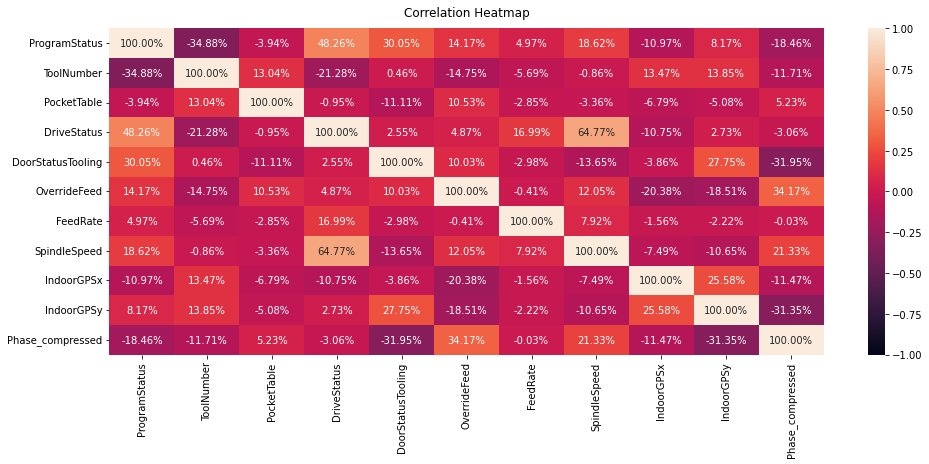

In [78]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2%')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


# Data preparation


In [79]:
# Splitting the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Using numpy to create arrays of lables and features
train_labels = np.array(train_df['Phase_compressed'])
test_labels = np.array(test_df['Phase_compressed'])
train_features = np.array(train_df.iloc[:, 0:10])
test_features = np.array(test_df.iloc[:, 0:10])

# Scaling the features using Standard Scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Having a look at the results
print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (17552,)
Test labels shape: (4388,)
Training features shape: (17552, 10)
Test features shape: (4388, 10)


In [80]:
train_labels

array([5, 5, 5, ..., 2, 2, 2])

# Decision Tree


In [9]:
# Create a Decision Tree classifier object
clf_DT = DecisionTreeClassifier(random_state=0)

# Train Decision Tree Classifier
clf_DT = clf_DT.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_DT = clf_DT.predict(test_features)

In [10]:
# Get the metrics for the Decision Tree
print(classification_report(test_labels,y_pred_DT))

              precision    recall  f1-score   support

           1       0.87      0.87      0.87       493
           2       0.89      0.90      0.90       749
           3       0.67      0.67      0.67       140
           4       0.88      0.90      0.89       451
           5       0.99      0.99      0.99      2357
           6       0.73      0.66      0.69       198

    accuracy                           0.93      4388
   macro avg       0.84      0.83      0.84      4388
weighted avg       0.93      0.93      0.93      4388



In [11]:
# Get macro average F1 score
f1_DT = f1_score(test_labels, y_pred_DT, average='macro')
f1_DT

0.8354244337402988

In [12]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_DT = matthews_corrcoef(test_labels, y_pred_DT)
MCC_DT

0.8915903563352169

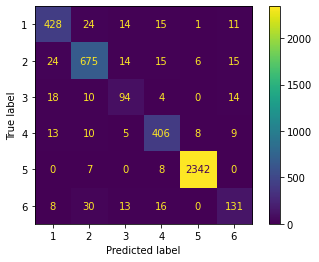

In [13]:
# Plot the confusion matrix for the Decision Tree
cm=confusion_matrix(test_labels,y_pred_DT,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

# Neural Network


In [81]:
# new Train and Validation Set for Neural Networks -> 70% Training, 10% Validation, 20% Test
train_NN_df, validation_df = train_test_split(train_df, test_size=0.125, random_state=0)

# Using numpy to create arrays of lables and features
train_NN_labels = np.array(train_NN_df['Phase_compressed'])
validation_labels = np.array(validation_df['Phase_compressed'])
train_NN_features = np.array(train_NN_df.iloc[:, 0:10])
validation_features = np.array(validation_df.iloc[:, 0:10])

print('Training NN labels shape:', train_NN_labels.shape)
print('Validation labels shape:', validation_labels.shape)
print('Training NN features shape:', train_NN_features.shape)
print('Validation features shape:', validation_features.shape)

# Scaling the features using Standard Scaler
train_NN_features = scaler.fit_transform(train_NN_features)
validation_features = scaler.transform(validation_features)


Training NN labels shape: (15358,)
Validation labels shape: (2194,)
Training NN features shape: (15358, 10)
Validation features shape: (2194, 10)


In [82]:
# Create neural network object
clf_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100,activation='relu',input_shape=(10,)),
    tf.keras.layers.Dropout(0.1), #prevention of overfitting
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(7,activation='softmax')
    ])

# Set up and train neural network
opt = keras.optimizers.Adam(learning_rate=0.01)
clf_NN.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = clf_NN.fit(train_NN_features,train_NN_labels, epochs=50, batch_size=50,validation_data=(validation_features, validation_labels))
clf_NN.evaluate(test_features, test_labels)

# Predict the response for the test dataset
y_pred_NN = clf_NN.predict(test_features,batch_size=1,verbose=0)

weights = clf_NN.get_weights() #returns a numpy list of weights

Epoch 1/50
308/308 [==============================] - 2s 5ms/step - loss: 0.5737 - accuracy: 0.8005 - val_loss: 0.4595 - val_accuracy: 0.8355
Epoch 2/50
308/308 [==============================] - 1s 4ms/step - loss: 0.4225 - accuracy: 0.8459 - val_loss: 0.4499 - val_accuracy: 0.8428
Epoch 3/50
308/308 [==============================] - 1s 5ms/step - loss: 0.3858 - accuracy: 0.8579 - val_loss: 0.3796 - val_accuracy: 0.8592
Epoch 4/50
308/308 [==============================] - 1s 5ms/step - loss: 0.3531 - accuracy: 0.8707 - val_loss: 0.3661 - val_accuracy: 0.8646
Epoch 5/50
308/308 [==============================] - 1s 5ms/step - loss: 0.3472 - accuracy: 0.8706 - val_loss: 0.3532 - val_accuracy: 0.8692
Epoch 6/50
308/308 [==============================] - 1s 4ms/step - loss: 0.3316 - accuracy: 0.8767 - val_loss: 0.3628 - val_accuracy: 0.8674
Epoch 7/50
308/308 [==============================] - 1s 5ms/step - loss: 0.3262 - accuracy: 0.8779 - val_loss: 0.3640 - val_accuracy: 0.8669
Epoch 

In [83]:
# Predicted values as integers
y_pred_NN = np.argmax(clf_NN.predict(test_features, batch_size=1, verbose=0), axis=-1)
print(y_pred_NN)

[5 2 2 ... 2 2 5]


In [84]:
# Get the metrics for the Neural Network
print(classification_report(test_labels,y_pred_NN))

              precision    recall  f1-score   support

           1       0.74      0.84      0.79       493
           2       0.82      0.85      0.83       749
           3       0.73      0.74      0.73       140
           4       0.90      0.81      0.85       451
           5       0.99      0.99      0.99      2357
           6       0.72      0.47      0.57       198

    accuracy                           0.90      4388
   macro avg       0.82      0.79      0.80      4388
weighted avg       0.90      0.90      0.90      4388



In [85]:
# Get macro average F1 score
f1_NN = f1_score(test_labels, y_pred_NN, average='macro')
f1_NN

0.7953175883641812

In [86]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_NN = matthews_corrcoef(test_labels, y_pred_NN)
MCC_NN

0.8479884355052476

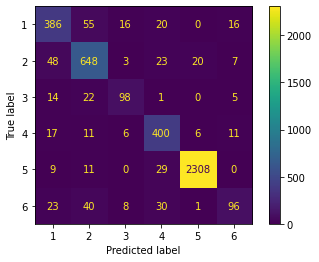

In [20]:
# Plot the confusion matrix for the Neural Network
cm=confusion_matrix(test_labels,y_pred_NN,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

# Balanced Random Forest


In [21]:
# Create a Balanced Random Forest classifier object
clf_BRF = BalancedRandomForestClassifier(random_state=42)

# Train the Balanced Random Forest Classifier
clf_BRF = clf_BRF.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_BRF = clf_BRF.predict(test_features)

In [22]:
# Get the metrics for the Balanced Random Forest
print(classification_report(test_labels,y_pred_BRF))

              precision    recall  f1-score   support

           1       0.93      0.86      0.89       493
           2       0.92      0.86      0.89       749
           3       0.63      0.89      0.74       140
           4       0.91      0.90      0.91       451
           5       0.99      0.99      0.99      2357
           6       0.68      0.80      0.73       198

    accuracy                           0.93      4388
   macro avg       0.84      0.88      0.86      4388
weighted avg       0.94      0.93      0.93      4388



In [23]:
# Get macro average F1 score
f1_BRF = f1_score(test_labels, y_pred_BRF, average='macro')
f1_BRF

0.8580125796498846

In [24]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_BRF = matthews_corrcoef(test_labels, y_pred_BRF)
MCC_BRF

0.8978684568651439

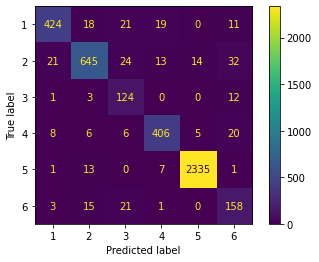

In [25]:
# Plot the confusion matrix for the Balanced Random Forest
cm=confusion_matrix(test_labels,y_pred_BRF,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

# Random Forest


In [26]:
# Create a Random Forest classifier object with best parameters found via grid search
clf_RF = RandomForestClassifier(random_state=0)

# Train the Random Forest Classifier
clf_RF = clf_RF.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_RF = clf_RF.predict(test_features)

In [27]:
# Get the metrics for the Random Tree
print(classification_report(test_labels,y_pred_RF))

              precision    recall  f1-score   support

           1       0.88      0.89      0.89       493
           2       0.92      0.91      0.92       749
           3       0.69      0.74      0.71       140
           4       0.90      0.92      0.91       451
           5       0.99      1.00      1.00      2357
           6       0.76      0.66      0.71       198

    accuracy                           0.94      4388
   macro avg       0.86      0.85      0.85      4388
weighted avg       0.94      0.94      0.94      4388



In [28]:
# Get macro average F1 score
f1_RF = f1_score(test_labels, y_pred_RF, average='macro')
f1_RF

0.8543158780719503

In [29]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_RF = matthews_corrcoef(test_labels, y_pred_RF)
MCC_RF

0.9075376110096637

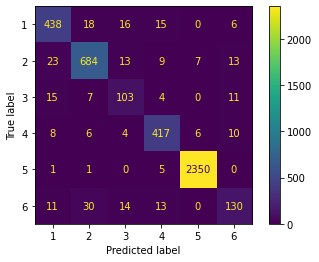

In [30]:
# Plot the confusion matrix for the Random Forest
cm=confusion_matrix(test_labels,y_pred_RF,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

# Extra trees

*Additional model that is not featured in the article. However, it looks very promising and is likely to be considered in the future research.*


In [31]:
# Create an Extra Trees classifier object
clf_ET = ExtraTreesClassifier(n_jobs=-1,random_state=0)

# Train Extra Trees Classifier
clf_ET = clf_ET.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_ET = clf_ET.predict(test_features)

In [32]:
# Get the metrics for the Extra Trees
print(classification_report(test_labels,y_pred_ET))

              precision    recall  f1-score   support

           1       0.88      0.89      0.88       493
           2       0.91      0.92      0.92       749
           3       0.69      0.70      0.70       140
           4       0.90      0.92      0.91       451
           5       1.00      1.00      1.00      2357
           6       0.77      0.67      0.71       198

    accuracy                           0.94      4388
   macro avg       0.86      0.85      0.85      4388
weighted avg       0.94      0.94      0.94      4388



In [33]:
# Get macro average F1 score
f1_ET = f1_score(test_labels, y_pred_ET, average='macro')
f1_ET

0.851479383891273

In [34]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_ET = matthews_corrcoef(test_labels, y_pred_ET)
MCC_ET

0.9061424049159458

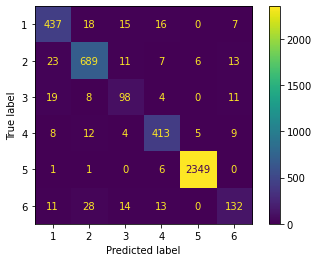

In [35]:
# Plot the confusion matrix for the Extra Trees
cm=confusion_matrix(test_labels,y_pred_ET,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

# SVC


In [36]:
# Create an SVC classifier object
clf_SVC = SVC(kernel='rbf', C=100000,random_state=0)

# Train the SVC Classifier
clf_SVC = clf_SVC.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_SVC = clf_SVC.predict(test_features)

In [37]:
# Get the metrics for the SVC
print(classification_report(test_labels,y_pred_SVC))

              precision    recall  f1-score   support

           1       0.82      0.85      0.83       493
           2       0.89      0.84      0.86       749
           3       0.68      0.82      0.75       140
           4       0.86      0.92      0.89       451
           5       0.99      0.99      0.99      2357
           6       0.76      0.64      0.69       198

    accuracy                           0.92      4388
   macro avg       0.83      0.84      0.84      4388
weighted avg       0.92      0.92      0.92      4388



In [38]:
# Get macro average F1 score
f1_SVC = f1_score(test_labels, y_pred_SVC, average='macro')
f1_SVC

0.8356861472094871

In [39]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_SVC = matthews_corrcoef(test_labels, y_pred_SVC)
MCC_SVC

0.8756606617818047

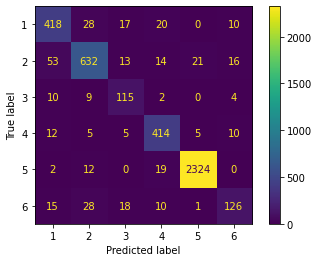

In [40]:
# Plot the confusion matrix for the SVC
cm=confusion_matrix(test_labels,y_pred_SVC,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

# Cat Boost

In [41]:
clf_cat = CatBoostClassifier(loss_function='MultiClass', random_seed=0)
clf_cat.fit(train_features, train_labels, verbose=False)

In [42]:
y_pred_cat = clf_cat.predict(test_features)
y_pred_cat

array([[5],
       [5],
       [2],
       ...,
       [2],
       [2],
       [5]])

In [43]:
print(classification_report(test_labels,y_pred_cat))

              precision    recall  f1-score   support

           1       0.89      0.88      0.88       493
           2       0.91      0.92      0.91       749
           3       0.70      0.79      0.74       140
           4       0.89      0.90      0.90       451
           5       0.99      1.00      0.99      2357
           6       0.79      0.61      0.69       198

    accuracy                           0.94      4388
   macro avg       0.86      0.85      0.85      4388
weighted avg       0.94      0.94      0.94      4388



In [44]:
# Get macro average F1 score
f1_CAT= f1_score(test_labels, y_pred_cat, average='macro')
f1_CAT

0.853892962838673

In [45]:
MCC_CAT = matthews_corrcoef(test_labels, y_pred_cat)
MCC_CAT

0.9047196890393404

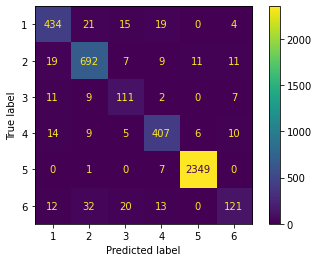

In [46]:
# Plot the confusion matrix for Catboost
cm=confusion_matrix(test_labels,y_pred_cat,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

# LightGBM 


In [47]:
clf_gbm=lgb.LGBMClassifier(random_state=0)
clf_gbm.fit(train_features,train_labels)

LGBMClassifier(random_state=0)

In [48]:
y_pred_gbm = clf_gbm.predict(test_features)
y_pred_gbm

array([5, 5, 2, ..., 2, 2, 5])

In [49]:
print(classification_report(test_labels,y_pred_gbm))

              precision    recall  f1-score   support

           1       0.88      0.88      0.88       493
           2       0.90      0.91      0.91       749
           3       0.70      0.77      0.73       140
           4       0.89      0.90      0.90       451
           5       1.00      1.00      1.00      2357
           6       0.75      0.63      0.69       198

    accuracy                           0.94      4388
   macro avg       0.85      0.85      0.85      4388
weighted avg       0.94      0.94      0.94      4388



In [50]:
# Get macro average F1 score
f1_GBM = f1_score(test_labels, y_pred_gbm, average='macro')
f1_GBM

0.8506234218576413

In [51]:
MCC_GBM = matthews_corrcoef(test_labels, y_pred_gbm)
MCC_GBM

0.9023600031964348

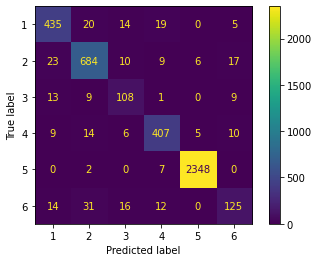

In [52]:
# Plot the confusion matrix for Light Gradient Boosting
cm=confusion_matrix(test_labels,y_pred_gbm,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

## Extreme Gradient Boost


In [53]:
clf_xgb=xgb.XGBClassifier(objective='multi:softprob',random_state=0, verbosity=0);
clf_xgb.fit(train_features,train_labels);

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [54]:
y_pred_xgb = clf_xgb.predict(test_features)
y_pred_xgb

array([5, 2, 2, ..., 2, 2, 5])

In [55]:
print(classification_report(test_labels,y_pred_xgb))

              precision    recall  f1-score   support

           1       0.89      0.88      0.88       493
           2       0.89      0.93      0.91       749
           3       0.70      0.76      0.73       140
           4       0.91      0.91      0.91       451
           5       0.99      1.00      1.00      2357
           6       0.76      0.60      0.67       198

    accuracy                           0.94      4388
   macro avg       0.86      0.85      0.85      4388
weighted avg       0.94      0.94      0.94      4388



In [56]:
f1_XGB = f1_score(test_labels, y_pred_xgb, average='macro')
f1_XGB

0.8490671999336755

In [57]:
MCC_XGB = matthews_corrcoef(test_labels, y_pred_xgb)
MCC_XGB

0.9030190313194515

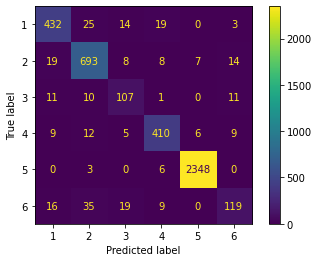

In [58]:
# Plot the confusion matrix for Extreme Gradient Boosting
cm=confusion_matrix(test_labels,y_pred_xgb,labels=[1,2,3,4,5,6])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot();

# Comparison tables

Cells below contain code to create a nice-looking table which compares F1, AUC and MCC of all algorithms used in OBerA.


In [87]:
# Create a skeleton of the table
comp_table = pd.DataFrame(index=['Neural Network', 'SVC', 'Decision Tree', 'Balanced Random Forest', 'Random Forest', 'Extra Trees','Catboost','LightGBM','XGBoost'], columns=['F1 score', 'MCC'])

In [88]:
# Add values to the table
comp_table.iloc[0] = [f1_NN, MCC_NN]
comp_table.iloc[1] = [f1_SVC, MCC_SVC] #if needed, put your SVC values here or simply remove "_static" from each parameter
comp_table.iloc[2] = [f1_DT, MCC_DT]
comp_table.iloc[3] = [f1_BRF, MCC_BRF]
comp_table.iloc[4] = [f1_RF, MCC_RF]
comp_table.iloc[5] = [f1_ET, MCC_ET]
comp_table.iloc[6] = [f1_CAT, MCC_CAT]
comp_table.iloc[7] = [f1_GBM, MCC_GBM]
comp_table.iloc[8] = [f1_XGB, MCC_XGB]

In [89]:
# Round all the values down to two digits
for i in range(len(comp_table)):
    comp_table.iloc[i] = comp_table.iloc[i].apply(lambda x: round(x, 2))

In [90]:
# Show the table
comp_table

,F1 score,MCC
Neural Network,0.8,0.85
SVC,0.84,0.88
Decision Tree,0.84,0.89
Balanced Random Forest,0.86,0.9
Random Forest,0.85,0.91
Extra Trees,0.85,0.91
Catboost,0.85,0.9
LightGBM,0.85,0.9
XGBoost,0.85,0.9
